# Project: No-show Appointments Data Analysis

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction

>The no-show appointments dataset contains information from 100,000 medical appointments in brazil. I will be using this dataset to draw inights about factors that contribute to patients missing their scheduled appointments and explore questions suh as:
> - are males more likely to miss their appointments than females?
> - do certain medical conditions have a higher rate of missed appoinments?
> - is age or financial status (scholarship) a factor in predicting whether a patient will show up?
> - is the notification system effective in informing/reminding patients of their appointments?
> - does the length of time between the scheduled date and appointment date influence whether a patient will show or not show?

In [104]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import dateutil.parser as dparser
import re
import seaborn as sns
%matplotlib inline

<a id='wrangling'></a>
## Data Wrangling

### General Properties

In [105]:
df=pd.read_csv('noshowappointments-kagglev2-may-2016.csv')
df.head(3)

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No


In [106]:
df.shape

(110527, 14)

In [107]:
#check datatypes of each column in the dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 14 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   PatientId       110527 non-null  float64
 1   AppointmentID   110527 non-null  int64  
 2   Gender          110527 non-null  object 
 3   ScheduledDay    110527 non-null  object 
 4   AppointmentDay  110527 non-null  object 
 5   Age             110527 non-null  int64  
 6   Neighbourhood   110527 non-null  object 
 7   Scholarship     110527 non-null  int64  
 8   Hipertension    110527 non-null  int64  
 9   Diabetes        110527 non-null  int64  
 10  Alcoholism      110527 non-null  int64  
 11  Handcap         110527 non-null  int64  
 12  SMS_received    110527 non-null  int64  
 13  No-show         110527 non-null  object 
dtypes: float64(1), int64(8), object(5)
memory usage: 11.8+ MB


In [108]:
#check for missing values
df.isnull().sum()

PatientId         0
AppointmentID     0
Gender            0
ScheduledDay      0
AppointmentDay    0
Age               0
Neighbourhood     0
Scholarship       0
Hipertension      0
Diabetes          0
Alcoholism        0
Handcap           0
SMS_received      0
No-show           0
dtype: int64

In [109]:
#check duplicates
sum(df.duplicated())

0

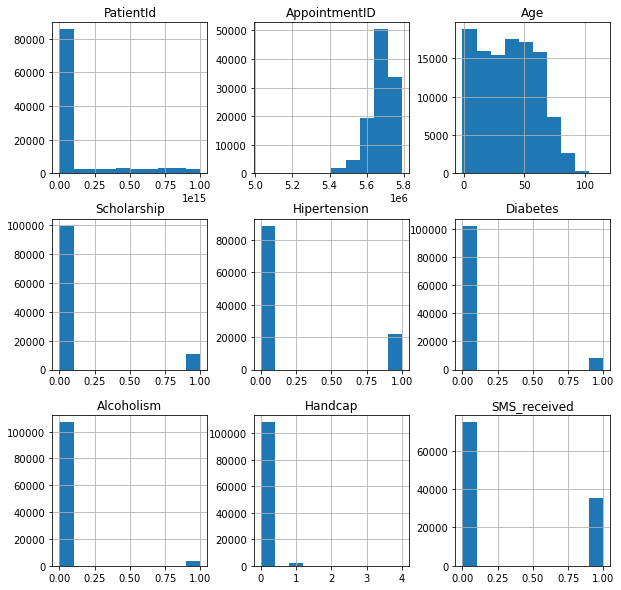

In [110]:
df.hist(figsize=(10,10));

In [111]:
df.describe()

,PatientId,AppointmentID,Age,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received
count,1.105270e+05,1.105270e+05,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000
mean,1.474963e+14,5.675305e+06,37.088874,0.098266,0.197246,0.071865,0.030400,0.022248,0.321026
std,2.560949e+14,7.129575e+04,23.110205,0.297675,0.397921,0.258265,0.171686,0.161543,0.466873
min,3.921784e+04,5.030230e+06,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.172614e+12,5.640286e+06,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.173184e+13,5.680573e+06,37.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,9.439172e+13,5.725524e+06,55.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,9.999816e+14,5.790484e+06,115.000000,1.000000,1.000000,1.000000,1.000000,4.000000,1.000000


In [112]:
df.Handcap.unique()

array([0, 1, 2, 3, 4], dtype=int64)

In [113]:
df.Age.value_counts()

 0      3539
 1      2273
 52     1746
 49     1652
 53     1651
        ... 
 115       5
 100       4
 102       2
 99        1
-1         1
Name: Age, Length: 104, dtype: int64

### Data Cleaning 

>To make it easier to type and remember the features, I will convert the names from camel case to snake case and make everything lowercase. Hypertension is mispelled as Hipertension. It is also very likely that Handicap was incorrectly spelled as Handcap. I will fix the typos in this section.

>'PatientId' and 'AppointmentID' are not important for our analysis, so we can drop these feature from the dataframe. 
>'AppointmentDate' and 'ScheduledDate' is in string format, We will need to convert from string to date format.

>There are no duplicate or missing values in the dataframe. However, the descriptive statistics shows an incorrect age value of -1. We will need to exclude this row from our analysis since it's impossible for age to be negative.



In [114]:
# Dataset trimming
df.drop(['PatientId','AppointmentID'],axis=1,inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 12 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   Gender          110527 non-null  object
 1   ScheduledDay    110527 non-null  object
 2   AppointmentDay  110527 non-null  object
 3   Age             110527 non-null  int64 
 4   Neighbourhood   110527 non-null  object
 5   Scholarship     110527 non-null  int64 
 6   Hipertension    110527 non-null  int64 
 7   Diabetes        110527 non-null  int64 
 8   Alcoholism      110527 non-null  int64 
 9   Handcap         110527 non-null  int64 
 10  SMS_received    110527 non-null  int64 
 11  No-show         110527 non-null  object
dtypes: int64(7), object(5)
memory usage: 10.1+ MB


In [115]:
df.rename(columns=lambda x:re.sub(r'(?<!^)(?=[A-Z])' ,'_',x).lower(), inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 12 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   gender           110527 non-null  object
 1   scheduled_day    110527 non-null  object
 2   appointment_day  110527 non-null  object
 3   age              110527 non-null  int64 
 4   neighbourhood    110527 non-null  object
 5   scholarship      110527 non-null  int64 
 6   hipertension     110527 non-null  int64 
 7   diabetes         110527 non-null  int64 
 8   alcoholism       110527 non-null  int64 
 9   handcap          110527 non-null  int64 
 10  s_m_s_received   110527 non-null  int64 
 11  no-show          110527 non-null  object
dtypes: int64(7), object(5)
memory usage: 10.1+ MB


In [116]:
df.rename(columns={"s_m_s_received":"sms_received","no-show":"no_show","handcap":"handicap","hipertension":"hypertension"},inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 12 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   gender           110527 non-null  object
 1   scheduled_day    110527 non-null  object
 2   appointment_day  110527 non-null  object
 3   age              110527 non-null  int64 
 4   neighbourhood    110527 non-null  object
 5   scholarship      110527 non-null  int64 
 6   hypertension     110527 non-null  int64 
 7   diabetes         110527 non-null  int64 
 8   alcoholism       110527 non-null  int64 
 9   handicap         110527 non-null  int64 
 10  sms_received     110527 non-null  int64 
 11  no_show          110527 non-null  object
dtypes: int64(7), object(5)
memory usage: 10.1+ MB


In [117]:
# fixing datatypes
df['scheduled_day']=df.scheduled_day.str.slice(0, 10).astype('datetime64[ns]')
df['appointment_day']=df.appointment_day.str.slice(0, 10).astype('datetime64[ns]')
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 12 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   gender           110527 non-null  object        
 1   scheduled_day    110527 non-null  datetime64[ns]
 2   appointment_day  110527 non-null  datetime64[ns]
 3   age              110527 non-null  int64         
 4   neighbourhood    110527 non-null  object        
 5   scholarship      110527 non-null  int64         
 6   hypertension     110527 non-null  int64         
 7   diabetes         110527 non-null  int64         
 8   alcoholism       110527 non-null  int64         
 9   handicap         110527 non-null  int64         
 10  sms_received     110527 non-null  int64         
 11  no_show          110527 non-null  object        
dtypes: datetime64[ns](2), int64(7), object(3)
memory usage: 10.1+ MB
None


In [118]:
#feature engineering
df['waiting_period']=(df['appointment_day']-df['scheduled_day']).dt.days
df.head()

,gender,scheduled_day,appointment_day,age,neighbourhood,scholarship,hypertension,diabetes,alcoholism,handicap,sms_received,no_show,waiting_period
0,F,2016-04-29,2016-04-29,62,JARDIM DA PENHA,0,1,0,0,0,0,No,0
1,M,2016-04-29,2016-04-29,56,JARDIM DA PENHA,0,0,0,0,0,0,No,0
2,F,2016-04-29,2016-04-29,62,MATA DA PRAIA,0,0,0,0,0,0,No,0
3,F,2016-04-29,2016-04-29,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No,0
4,F,2016-04-29,2016-04-29,56,JARDIM DA PENHA,0,1,1,0,0,0,No,0


In [119]:
#recreate a binary version of the no_show column
df.loc[df['no_show'] == 'No', 'show'] = 1  
df.loc[df['no_show'] != 'No', 'show'] = 0 
#df_final['show'] = df_final['no_show'].apply(lambda x: 1 if x =="No" else 0)

df.head()

,gender,scheduled_day,appointment_day,age,neighbourhood,scholarship,hypertension,diabetes,alcoholism,handicap,sms_received,no_show,waiting_period,show
0,F,2016-04-29,2016-04-29,62,JARDIM DA PENHA,0,1,0,0,0,0,No,0,1.0
1,M,2016-04-29,2016-04-29,56,JARDIM DA PENHA,0,0,0,0,0,0,No,0,1.0
2,F,2016-04-29,2016-04-29,62,MATA DA PRAIA,0,0,0,0,0,0,No,0,1.0
3,F,2016-04-29,2016-04-29,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No,0,1.0
4,F,2016-04-29,2016-04-29,56,JARDIM DA PENHA,0,1,1,0,0,0,No,0,1.0


In [120]:
df=df[df['age']>=0]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 110526 entries, 0 to 110526
Data columns (total 14 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   gender           110526 non-null  object        
 1   scheduled_day    110526 non-null  datetime64[ns]
 2   appointment_day  110526 non-null  datetime64[ns]
 3   age              110526 non-null  int64         
 4   neighbourhood    110526 non-null  object        
 5   scholarship      110526 non-null  int64         
 6   hypertension     110526 non-null  int64         
 7   diabetes         110526 non-null  int64         
 8   alcoholism       110526 non-null  int64         
 9   handicap         110526 non-null  int64         
 10  sms_received     110526 non-null  int64         
 11  no_show          110526 non-null  object        
 12  waiting_period   110526 non-null  int64         
 13  show             110526 non-null  float64       
dtypes: datetime64[ns](2)

In [121]:
df.tail()

,gender,scheduled_day,appointment_day,age,neighbourhood,scholarship,hypertension,diabetes,alcoholism,handicap,sms_received,no_show,waiting_period,show
110522,F,2016-05-03,2016-06-07,56,MARIA ORTIZ,0,0,0,0,0,1,No,35,1.0
110523,F,2016-05-03,2016-06-07,51,MARIA ORTIZ,0,0,0,0,0,1,No,35,1.0
110524,F,2016-04-27,2016-06-07,21,MARIA ORTIZ,0,0,0,0,0,1,No,41,1.0
110525,F,2016-04-27,2016-06-07,38,MARIA ORTIZ,0,0,0,0,0,1,No,41,1.0
110526,F,2016-04-27,2016-06-07,54,MARIA ORTIZ,0,0,0,0,0,1,No,41,1.0


<a id='eda'></a>
## Exploratory Data Analysis

### Question 1: which age group is more likely to miss appoinments?

A quick way to answer this question is to plot age histograms for the show vs noshow populations.   

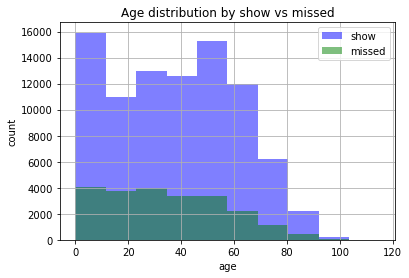

In [122]:
#age distribution
show = df[df['no_show'] == 'No']
missed = df[df['no_show'] == 'Yes']

def plot_dist(data1,data2,name1,name2,title,xlabel,ylabel):
    data1.hist(alpha=0.5, color='b', label=name1)
    data2.hist(alpha=0.5, color='g', label=name2)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend();

plot_dist(show.age,missed.age,'show','missed','Age distribution by show vs missed','age','count')

The 'missed' count is almost flat from age 0 to 60 and decreases sharply thereafter, but the 'show' count varies for each age group, the 'show' count is highest at age 0-10. This tell us that age 0-10 has a higher proportion of missed appointments than the other groups. To avoid the noise caused by the disparity in volumes per age group, and for us to make a clear comparison between ages I will work with the proportion of missed appointments as a percentage of the total for the age group.

Age is a numerical variable ranging from 0 up to 115, it wouldn't be practical to show each age as a single bar in a bar chart. We would need to buket the variable into age bands. To do this I will use age percentiles to get an idea of suitable age bands to use for my chart. 

In [123]:
df.age.describe()

count    110526.000000
mean         37.089219
std          23.110026
min           0.000000
25%          18.000000
50%          37.000000
75%          55.000000
max         115.000000
Name: age, dtype: float64

In [124]:
age_buckets=[0,18,37,55,115]
bucket_names=['0-18','19-37','38-55','56+']
df['age_groups']=pd.cut(df['age'],age_buckets,bucket_names)
df.head()

,gender,scheduled_day,appointment_day,age,neighbourhood,scholarship,hypertension,diabetes,alcoholism,handicap,sms_received,no_show,waiting_period,show,age_groups
0,F,2016-04-29,2016-04-29,62,JARDIM DA PENHA,0,1,0,0,0,0,No,0,1.0,"(55, 115]"
1,M,2016-04-29,2016-04-29,56,JARDIM DA PENHA,0,0,0,0,0,0,No,0,1.0,"(55, 115]"
2,F,2016-04-29,2016-04-29,62,MATA DA PRAIA,0,0,0,0,0,0,No,0,1.0,"(55, 115]"
3,F,2016-04-29,2016-04-29,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No,0,1.0,"(0, 18]"
4,F,2016-04-29,2016-04-29,56,JARDIM DA PENHA,0,1,1,0,0,0,No,0,1.0,"(55, 115]"


In [125]:
#show rate by age band
df.groupby('age_groups').show.mean()

age_groups
(0, 18]      0.774628
(18, 37]     0.764624
(37, 55]     0.804690
(55, 115]    0.843550
Name: show, dtype: float64

Using the mean of column 'show' is equivalent to calculating the proportion of show to the total.  

age_groups
(0, 18]      0.774628
(18, 37]     0.764624
(37, 55]     0.804690
(55, 115]    0.843550
Name: show, dtype: float64


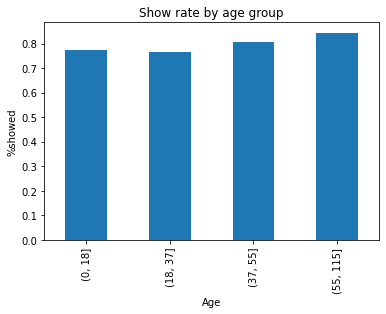

In [126]:
print(df.groupby(['age_groups']).show.mean())

df.groupby(['age_groups']).show.mean().plot(kind='bar')
plt.title('Show rate by age group')
plt.xlabel('Age')
plt.ylabel('%showed');

Both the bar chart and histogram show that younger patients miss their scheduled appointments more often than older patients. 


### Question 2: do males miss their appointments more often than females?

gender  no_show
F       No         57245
        Yes        14594
M       No         30962
        Yes         7725
Name: show, dtype: int64
gender
F    71839
M    38687
Name: show, dtype: int64
gender  no_show
F       No         0.796851
        Yes        0.203149
M       No         0.800321
        Yes        0.199679
Name: show, dtype: float64


<AxesSubplot:title={'center':'Proportion of show vs no show by gender'}, xlabel='Gender/No show', ylabel='proportion'>

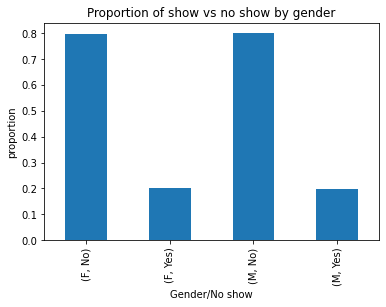

In [127]:
#Gender
def get_proportion(group1,group2,counter):
    count=df.groupby(group1)[counter].count()
    total=df.groupby(group2)[counter].count()
    proportion=count/total
    print(count)
    print(total)
    print(proportion)
    return proportion

data=get_proportion(['gender','no_show'],['gender'],'show')

data.plot(kind='bar',title='Proportion of show vs no show by gender',xlabel='Gender/No show', ylabel='proportion')

The proportion of 'No show' is similar across females and males, which tells us that there is no correlation between gender and a patient showing up or not.

### Question 3: is the notification system effective in informing/reminding patients of their appointments?

sms_received  no_show
0             No         62509
              Yes        12535
1             No         25698
              Yes         9784
Name: show, dtype: int64
sms_received
0    75044
1    35482
Name: show, dtype: int64
sms_received  no_show
0             No         0.832965
              Yes        0.167035
1             No         0.724255
              Yes        0.275745
Name: show, dtype: float64
no_show
No     0.724255
Yes    0.275745
Name: show, dtype: float64 no_show
No     0.832965
Yes    0.167035
Name: show, dtype: float64


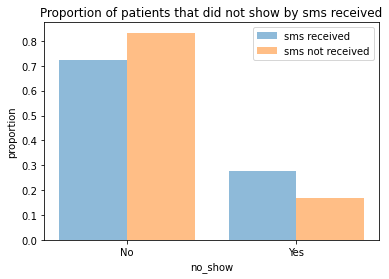

In [128]:
data=get_proportion(['sms_received','no_show'],['sms_received'],'show')
received=data[1]
not_received=data[0]
print(received,not_received)

def plot_double_bars(data1,data2,dlabel1,dlabel2,title,xaxis,yaxis,xlabels):
    location = np.arange(len(data1)) 
    plt.bar(location-0.2,data1,0.4,alpha=0.5, label=dlabel1)
    plt.bar(location+0.2,data2,0.4, alpha=0.5, label=dlabel2)
    plt.title(title)
    plt.xlabel(xaxis)
    plt.ylabel(yaxis) 
    plt.xticks(position, xlabels)
    plt.legend()

plot_double_bars(received,not_received,'sms received','sms not received',
                 'Proportion of patients that did not show by sms received',
                 'no_show','proportion',['No', 'Yes'])
  

The 'no show, yes' column tells us that most of those that didn't show had actually received an sms notification. Therefore it is safe to say that the system works well and that forgetfulnes was not the reason for patients failing to show up for their appointments.

### Question 4: is financial status (scholarship) a factor in predicting whether a patient will show up?

scholarship  no_show
0            No         79924
             Yes        19741
1            No          8283
             Yes         2578
Name: show, dtype: int64
scholarship
0    99665
1    10861
Name: show, dtype: int64
scholarship  no_show
0            No         0.801926
             Yes        0.198074
1            No         0.762637
             Yes        0.237363
Name: show, dtype: float64
no_show
No     0.762637
Yes    0.237363
Name: show, dtype: float64 no_show
No     0.801926
Yes    0.198074
Name: show, dtype: float64


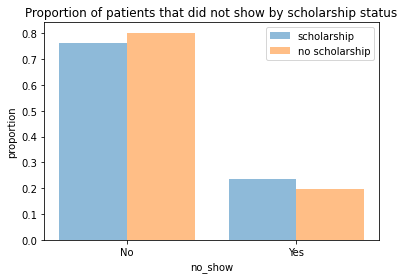

In [129]:
data=get_proportion(['scholarship','no_show'],['scholarship'],'show')
scholarship=data[1]
no_scholarship=data[0]
print(scholarship,no_scholarship)

plot_double_bars(scholarship,no_scholarship,'scholarship','no scholarship',
                 'Proportion of patients that did not show by scholarship status',
                 'no_show','proportion',['No', 'Yes'])
  

Patients on welfare seem to miss appointments more often than well off patients,which tells us that scholarship is positively correlated with wether a patient misses or makes it to their scheduled appointment. 

 ### Question 4: do certain medical conditions have a higher rate of missed appoinments?

hypertension  no_show
0             No         70178
              Yes        18547
1             No         18029
              Yes         3772
Name: show, dtype: int64
hypertension
0    88725
1    21801
Name: show, dtype: int64
hypertension  no_show
0             No         0.790961
              Yes        0.209039
1             No         0.826980
              Yes        0.173020
Name: show, dtype: float64


<AxesSubplot:title={'center':'Proportion of show vs no show by hypertension status'}, xlabel='hypertension status/No show', ylabel='proportion'>

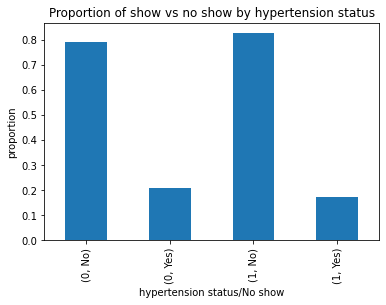

In [130]:
#hypertension

data=get_proportion(['hypertension','no_show'],['hypertension'],'show')

data.plot(kind='bar',title='Proportion of show vs no show by hypertension status',
          xlabel='hypertension status/No show', ylabel='proportion')


diabetes  no_show
0         No         81694
          Yes        20889
1         No          6513
          Yes         1430
Name: show, dtype: int64
diabetes
0    102583
1      7943
Name: show, dtype: int64
diabetes  no_show
0         No         0.796370
          Yes        0.203630
1         No         0.819967
          Yes        0.180033
Name: show, dtype: float64


<AxesSubplot:title={'center':'Proportion of show vs no show by diabetes status'}, xlabel='diabetes status/No show', ylabel='proportion'>

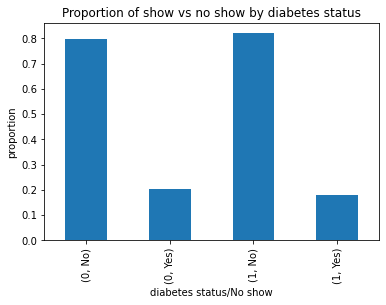

In [131]:
#Diabetes
data=get_proportion(['diabetes','no_show'],['diabetes'],'show')

data.plot(kind='bar',title='Proportion of show vs no show by diabetes status',
          xlabel='diabetes status/No show', ylabel='proportion')

The rate in which patients missed their appointments is lower for patients suffering from either medical conditions, diabetes and hypertension, than those that are otherwise free from the condition.

### Question 5: does the length of time between the scheduled date and appointment date influence whether a patient will show or not show?

In [132]:
df.groupby(['no_show']).waiting_period.describe()

,count,mean,std,min,25%,50%,75%,max
no_show,,,,,,,,
No,88207.0,8.754759,14.550450,0.0,0.0,2.0,12.0,179.0
Yes,22319.0,15.831489,16.605912,-6.0,4.0,11.0,23.0,179.0


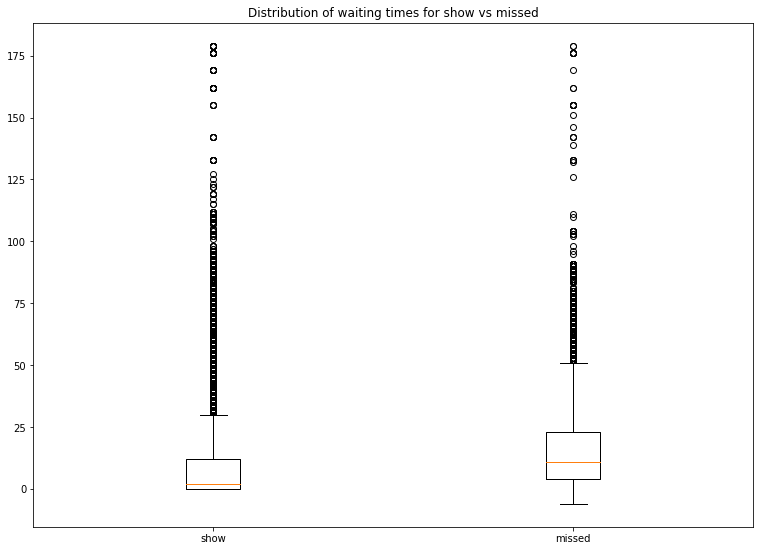

In [133]:
data=[show['waiting_period'],missed['waiting_period']]
fig = plt.figure(figsize =(10, 7))
axis = fig.add_axes([0,0,1,1])
 
# plot
axis.boxplot(data)
plt.title("Distribution of waiting times for show vs missed")
axis.set_xticklabels(['show', 'missed']);

The 'show' box plot is shorter than the 'missed' box plot which suggests that the 'show' population has shorter waiting times than the 'missed' population.

<a id='conclusions'></a>
## Conclusions

>The vizualizations in the above section show that patients that suffer from a chronic disease such as diabetes or hypertension are more likely to show up for their medical appointment than those that do not. Older patients also tend to follow through with their appointments compared to younger patients.

> Sms received and Gender seem to have a low correlation with whether a patient shows up for appointments. On the other hand Scholarship is positively correlated with showing up.

> When patients have a long waiting period from the time they scheduled their appointments to the actual appointment date, the patients tend to not show up.

### Limitations

> In order to make a definite conclusion about what factors can predict if a patient will show up for their appointment we would need to perform statistical tests. 

> While my analysis explored a few factors that could potentially predict show/no show for medical appointments, this does not mean that other factors do not exist. I was only able to look at factors that were provided in the data.

> From the features provided, it was not possible for me to do further investigations on handicap and neighbourhood. With neighbourhood, the list of possible neighbourhoods is long and would require me to combine the neighbourhoods into more meaningful groups to do proper analysis. Handicap has values from 0 to 4, but no details were given to explain what each category represents. 
